# Understanding Autoencoders


## Dataset Source

- [Kaggle]()

In [27]:
!bash dataset_fetch.sh

+ '[' '!' -d dataset ']'
+ echo 'Dataset Directory already exist!'
Dataset Directory already exist!


In [17]:
# Helper Cell

from PIL import Image
import matplotlib.pyplot as plt
import math

def helper_imageGrid(image_paths, cols=4):
    img_count = len(image_paths)
    rows = math.ceil(img_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    irow, icol = 0, 0
    for path in image_paths:
        ax = axes[irow][icol]
        ax.imshow(Image.open(path))
        title = path.split("/")[-2]
        #ax.title(path)
        ax.axis("off")

        icol += 1
        if icol % cols == 0:
            icol = 0
            irow += 1

        
    
    return fig




In [18]:
import os
import random

image_paths = [ f"dataset/GAID/Soul/{x}" for x in os.listdir("dataset/GAID/Soul") ]


sizes = set()
for x in image_paths:
    img = Image.open(x)
    sizes.add(img.size)
    img.close()

print("Sizes of Images: ", sizes)
print("Count of Images: ", len(image_paths))



Sizes of Images:  {(300, 300)}
Count of Images:  1000


In [19]:
import torch
from torch import nn
import numpy as np
'''

100x100 --> 10x10 --> 10 --> 10x10 --> 100x100

'''

device = "cuda" if torch.cuda.is_available() else "cpu"

class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100**2, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))





def ReconstructionLoss(reproduced, original): return torch.sum((original - reproduced)**2)




In [20]:
from torchvision import transforms

def todata(path):
    image = Image.open(path).convert("L").resize((100, 100))
    tensor = transforms.ToTensor()(image)
    tensor = nn.Flatten(0)(tensor)
    image.close()
    return tensor
    
def toimg(data):
    data = nn.Sigmoid()(data.view(100, 100)) * 255
    return np.uint8(data.detach().numpy())
    

In [22]:
auto = Autoencoder()

epochs = 100
optimizer = torch.optim.Adam(auto.parameters(),lr=0.001)
for epoch in range(epochs):
    for path in image_paths:
        optimizer.zero_grad()
        sample = todata(path)
        op = auto(sample)
        loss = ReconstructionLoss(sample, op)
        loss.backward()
        optimizer.step()
    print(f"Epoch Completed: {epoch}")

Epoch Completed: 0
Epoch Completed: 1
Epoch Completed: 2
Epoch Completed: 3
Epoch Completed: 4
Epoch Completed: 5
Epoch Completed: 6
Epoch Completed: 7
Epoch Completed: 8
Epoch Completed: 9
Epoch Completed: 10
Epoch Completed: 11
Epoch Completed: 12
Epoch Completed: 13
Epoch Completed: 14
Epoch Completed: 15
Epoch Completed: 16
Epoch Completed: 17
Epoch Completed: 18
Epoch Completed: 19
Epoch Completed: 20
Epoch Completed: 21
Epoch Completed: 22
Epoch Completed: 23
Epoch Completed: 24
Epoch Completed: 25
Epoch Completed: 26
Epoch Completed: 27
Epoch Completed: 28
Epoch Completed: 29
Epoch Completed: 30
Epoch Completed: 31
Epoch Completed: 32
Epoch Completed: 33
Epoch Completed: 34
Epoch Completed: 35
Epoch Completed: 36
Epoch Completed: 37
Epoch Completed: 38
Epoch Completed: 39
Epoch Completed: 40
Epoch Completed: 41
Epoch Completed: 42
Epoch Completed: 43
Epoch Completed: 44
Epoch Completed: 45
Epoch Completed: 46


KeyboardInterrupt: 

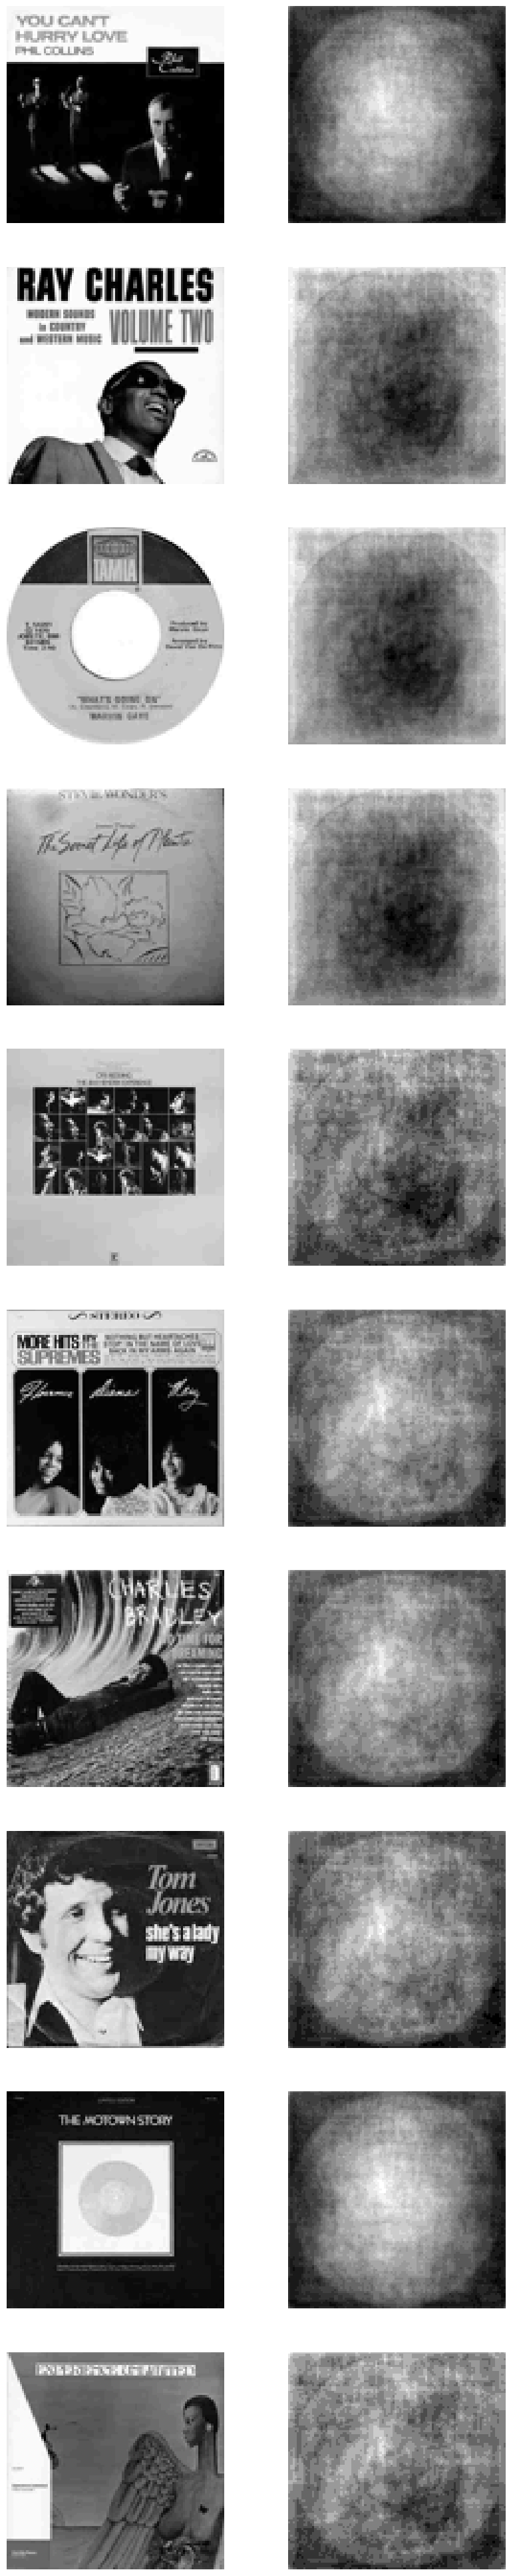

In [35]:
show_count = 10

fig, axes = plt.subplots(show_count, 2, figsize=(10, show_count * 5))

for i, path in enumerate(image_paths[:show_count]):
    data = todata(path)
    infer = auto(data)
    axes[i][0].imshow(toimg(data), cmap="gray")
    axes[i][0].axis("off")
    axes[i][1].imshow(toimg(infer), cmap="gray")
    axes[i][1].axis("off")

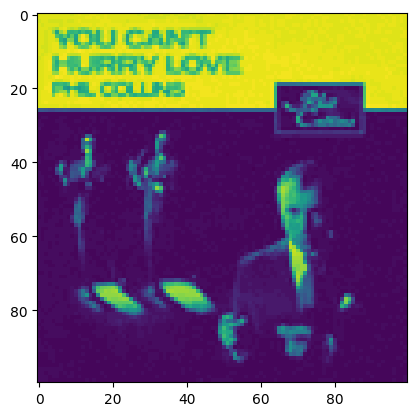

In [119]:
blu_image_paths = [ f"dataset/GAID/Soul/{x}" for x in os.listdir("dataset/GAID/Soul/")]

data = toimg(auto(todata(blu_image_paths[10])))

plt.imshow(data)

Help on class ToTensor in module torchvision.transforms.transforms:

class ToTensor(builtins.object)
 |  ToTensor() -> None
 |
 |  Convert a PIL Image or ndarray to tensor and scale the values accordingly.
 |
 |  This transform does not support torchscript.
 |
 |  Converts a PIL Image or numpy.ndarray (H x W x C) in the range
 |  [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
 |  if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
 |  or if the numpy.ndarray has dtype = np.uint8
 |
 |  In the other cases, tensors are returned without scaling.
 |
 |  .. note::
 |      Because the input image is scaled to [0.0, 1.0], this transformation should not be used when
 |      transforming target image masks. See the `references`_ for implementing the transforms for image masks.
 |
 |  .. _references: https://github.com/pytorch/vision/tree/main/references/segmentation
 |
 |  Methods defined here:
 |
 |  __call__(self, pic)
 |     